# Part 1 - Apriori

In [463]:
# (c) 2016 Everaldo Aguiar & Reid Johnson
#
# Modified from:
# Marcel Caraciolo (https://gist.github.com/marcelcaraciolo/1423287)
#
# Functions to compute and extract association rules from a given frequent itemset 
# generated by the Apriori algorithm.
#
# The Apriori algorithm is defined by Agrawal and Srikant in:
# Fast algorithms for mining association rules
# Proc. 20th int. conf. very large data bases, VLDB. Vol. 1215. 1994
import csv
import numpy as np

def load_dataset(filename):
    '''Loads an example of market basket transactions from a provided csv file.

    Returns: A list (database) of lists (transactions). Each element of a transaction is 
    an item.
    '''

    with open(filename,'r') as dest_f:
        data_iter = csv.reader(dest_f, delimiter = ',', quotechar = '"')
        data = [data for data in data_iter]
        data_array = np.asarray(data)
        
    return data_array

def apriori(dataset, min_support=0.5, verbose=False):
    """Implements the Apriori algorithm.

    The Apriori algorithm will iteratively generate new candidate 
    k-itemsets using the frequent (k-1)-itemsets found in the previous 
    iteration.

    Parameters
    ----------
    dataset : list
        The dataset (a list of transactions) from which to generate 
        candidate itemsets.

    min_support : float
        The minimum support threshold. Defaults to 0.5.

    Returns
    -------
    F : list
        The list of frequent itemsets.

    support_data : dict
        The support data for all candidate itemsets.

    References
    ----------
    .. [1] R. Agrawal, R. Srikant, "Fast Algorithms for Mining Association 
           Rules", 1994.

    """
    print("candidates: ",'\n')
    C1 = create_candidates(dataset, verbose = True)
    D = list(map(set, dataset))
    print("prune candidates below min support: ",'\n')
    F1, support_data = support_prune(D, C1, min_support, verbose=True) # prune candidate 1-itemsets
    F = [F1] # list of frequent itemsets; initialized to frequent 1-itemsets
    k = 2 # the itemset cardinality
    while (len(F[k - 2]) > 0):
        Ck = apriori_gen(F[k-2], k) # generate candidate itemsets
        Fk, supK = support_prune(D, Ck, min_support) # prune candidate itemsets
        support_data.update(supK) # update the support counts to reflect pruning
        F.append(Fk) # add the pruned candidate itemsets to the list of frequent itemsets
        k += 1
    print("frequent itemset list: ",'\n')
    if verbose:
        # Print a list of all the frequent itemsets.
        for kset in F:
            for item in kset:
                print("" \
                    + "{" \
                    + "".join(str(i) + ", " for i in iter(item)).rstrip(', ') \
                    + "}" \
                    + ":  sup = " + str(round(support_data[item], 3)))

    return F, support_data

def create_candidates(dataset, verbose=False):
    """Creates a list of candidate 1-itemsets from a list of transactions.

    Parameters
    ----------
    dataset : list
        The dataset (a list of transactions) from which to generate candidate 
        itemsets.

    Returns
    -------
    The list of candidate itemsets (c1) passed as a frozenset (a set that is 
    immutable and hashable).
    """
    c1 = [] # list of all items in the database of transactions
    for transaction in dataset:
        for item in transaction:
            if not [item] in c1:
                c1.append([item])
    c1.sort()

    if verbose:
        # Print a list of all the candidate items.
        print("" \
            + "{" \
            + "".join(str(i[0]) + ", " for i in iter(c1)).rstrip(', ') \
            + "}")
        print('\n')

    # Map c1 to a frozenset because it will be the key of a dictionary.
    return list(map(frozenset, c1))

def support_prune(dataset, candidates, min_support, verbose=False):
    """Returns all candidate itemsets that meet a minimum support threshold.

    By the apriori principle, if an itemset is frequent, then all of its 
    subsets must also be frequent. As a result, we can perform support-based 
    pruning to systematically control the exponential growth of candidate 
    itemsets. Thus, itemsets that do not meet the minimum support level are 
    pruned from the input list of itemsets (dataset).

    Parameters
    ----------
    dataset : list
        The dataset (a list of transactions) from which to generate candidate 
        itemsets.

    candidates : frozenset
        The list of candidate itemsets.

    min_support : float
        The minimum support threshold.

    Returns
    -------
    retlist : list
        The list of frequent itemsets.

    support_data : dict
        The support data for all candidate itemsets.
    """
    sscnt = {} # set for support counts
    for tid in dataset:
        for can in candidates:
            if can.issubset(tid):
                sscnt.setdefault(can, 0)
                sscnt[can] += 1

    num_items = float(len(dataset)) # total number of transactions in the dataset
    retlist = [] # array for unpruned itemsets
    support_data = {} # set for support data for corresponding itemsets
    for key in sscnt:
        # Calculate the support of itemset key.
        support = sscnt[key] / num_items
        if support >= min_support:
            retlist.insert(0, key)
        support_data[key] = support

    # Print a list of the pruned itemsets.
    if verbose:
        for kset in retlist:
            for item in kset:
                print("{" + str(item) + "}")
        print("")
        for key in sscnt:
            print("" \
                + "{" \
                + "".join([str(i) + ", " for i in iter(key)]).rstrip(', ') \
                + "}" \
                + ":  sup = " + str(support_data[key]))
        print('\n')

    return retlist, support_data

def apriori_gen(freq_sets, k):
    """Generates candidate itemsets (via the F_k-1 x F_k-1 method).

    This operation generates new candidate k-itemsets based on the frequent 
    (k-1)-itemsets found in the previous iteration. The candidate generation 
    procedure merges a pair of frequent (k-1)-itemsets only if their first k-2 
    items are identical.

    Parameters
    ----------
    freq_sets : list
        The list of frequent (k-1)-itemsets.

    k : integer
        The cardinality of the current itemsets being evaluated.

    Returns
    -------
    retlist : list
        The list of merged frequent itemsets.
    """
    retList = [] # list of merged frequent itemsets
    lenLk = len(freq_sets) # number of frequent itemsets
    for i in range(lenLk):
        for j in range(i+1, lenLk):
            a=list(freq_sets[i])
            b=list(freq_sets[j])
            a.sort()
            b.sort()
            F1 = a[:k-2] # first k-2 items of freq_sets[i]
            F2 = b[:k-2] # first k-2 items of freq_sets[j]

            if F1 == F2: # if the first k-2 items are identical
                # Merge the frequent itemsets.
                retList.append(freq_sets[i] | freq_sets[j])

    return retList

def rules_from_conseq(freq_set, H, support_data, rules, min_confidence=0.5, verbose=False):
    """Generates a set of candidate rules.

    Parameters
    ----------
    freq_set : frozenset
        The complete list of frequent itemsets.

    H : list
        A list of frequent itemsets (of a particular length).

    support_data : dict
        The support data for all candidate itemsets.

    rules : list
        A potentially incomplete set of candidate rules above the minimum 
        confidence threshold.

    min_confidence : float
        The minimum confidence threshold. Defaults to 0.5.
    """
    m = len(H[0])
    if m == 1:
        Hmp1 = calc_confidence(freq_set, H, support_data, rules, min_confidence, verbose)
    if (len(freq_set) > (m+1)):
        Hmp1 = apriori_gen(H, m+1) # generate candidate itemsets
        Hmp1 = calc_confidence(freq_set, Hmp1, support_data, rules, min_confidence, verbose)
        if len(Hmp1) > 1:
            # If there are candidate rules above the minimum confidence 
            # threshold, recurse on the list of these candidate rules.
            rules_from_conseq(freq_set, Hmp1, support_data, rules, min_confidence, verbose)

            
def calc_confidence(freq_set, H, support_data, rules, min_confidence=0.5, verbose=False):
    """Evaluates the generated rules.

    One measurement for quantifying the goodness of association rules is 
    confidence. The confidence for a rule 'P implies H' (P -> H) is defined as 
    the support for P and H divided by the support for P 
    (support (P|H) / support(P)), where the | symbol denotes the set union 
    (thus P|H means all the items in set P or in set H).

    To calculate the confidence, we iterate through the frequent itemsets and 
    associated support data. For each frequent itemset, we divide the support 
    of the itemset by the support of the antecedent (left-hand-side of the 
    rule).

    Parameters
    ----------
    freq_set : frozenset
        The complete list of frequent itemsets.

    H : list
        A list of frequent itemsets (of a particular length).

    min_support : float
        The minimum support threshold.

    rules : list
        A potentially incomplete set of candidate rules above the minimum 
        confidence threshold.

    min_confidence : float
        The minimum confidence threshold. Defaults to 0.5.

    Returns
    -------
    pruned_H : list
        The list of candidate rules above the minimum confidence threshold.
    """
    pruned_H = [] # list of candidate rules above the minimum confidence threshold
    for conseq in H: # iterate over the frequent itemsets
        conf = support_data[freq_set] / support_data[freq_set - conseq]
        if conf >= min_confidence:
            rules.append((freq_set - conseq, conseq, conf))
            pruned_H.append(conseq)

            if verbose:
                print("" \
                    + "{" \
                    + "".join([str(i) + ", " for i in iter(freq_set-conseq)]).rstrip(', ') \
                    + "}" \
                    + " ---> " \
                    + "{" \
                    + "".join([str(i) + ", " for i in iter(conseq)]).rstrip(', ') \
                    + "}" \
                    + ":  conf = " + str(round(conf, 3)) \
                    + ", sup = " + str(round(support_data[freq_set], 3)))

    return pruned_H

def generate_rules(F, support_data, min_confidence=0.5, verbose=True):
    """Generates a set of candidate rules from a list of frequent itemsets.

    For each frequent itemset, we calculate the confidence of using a
    particular item as the rule consequent (right-hand-side of the rule). By 
    testing and merging the remaining rules, we recursively create a list of 
    pruned rules.

    Parameters
    ----------
    F : list
        A list of frequent itemsets.

    support_data : dict
        The corresponding support data for the frequent itemsets (L).

    min_confidence : float
        The minimum confidence threshold. Defaults to 0.5.

    Returns
    -------
    rules : list
        The list of candidate rules above the minimum confidence threshold.
    """
    rules = []
    for i in range(1, len(F)):
        for freq_set in F[i]:
            H1 = [frozenset([itemset]) for itemset in freq_set]
            if (i > 1):
                rules_from_conseq(freq_set, H1, support_data, rules, min_confidence, verbose)
            else:
                calc_confidence(freq_set, H1, support_data, rules, min_confidence, verbose)

    return rules

## To load our dataset of grocery transactions, use the command below

In [464]:
dataset = load_dataset('grocery.csv')
D = list(map(set, dataset))

/var/folders/w7/4qn17rqj6dj91d1s17qbtz700000gn/T/ipykernel_85112/4209155785.py:25: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  data_array = np.asarray(data)


## dataset is now a ndarray containing each of the 9835 transactions

In [465]:
type(dataset)

numpy.ndarray

In [466]:
dataset.shape

(9835,)

In [467]:
dataset[0]

['citrus fruit', 'semi-finished bread', 'margarine', 'ready soups']

In [468]:
dataset[1]

['tropical fruit', 'yogurt', 'coffee']

## D Contains that dataset in a set format (which excludes duplicated items and sorts them)

In [469]:
type(D[0])

set

In [470]:
D[0]

{'citrus fruit', 'margarine', 'ready soups', 'semi-finished bread'}

#### Generate candidate itemsets

In [471]:
C1 = create_candidates(dataset, verbose=True) # candidate 1-itemsets
#len(C1)

{Instant food products, UHT-milk, abrasive cleaner, artif. sweetener, baby cosmetics, baby food, bags, baking powder, bathroom cleaner, beef, berries, beverages, bottled beer, bottled water, brandy, brown bread, butter, butter milk, cake bar, candles, candy, canned beer, canned fish, canned fruit, canned vegetables, cat food, cereals, chewing gum, chicken, chocolate, chocolate marshmallow, citrus fruit, cleaner, cling film/bags, cocoa drinks, coffee, condensed milk, cooking chocolate, cookware, cream, cream cheese , curd, curd cheese, decalcifier, dental care, dessert, detergent, dish cleaner, dishes, dog food, domestic eggs, female sanitary products, finished products, fish, flour, flower (seeds), flower soil/fertilizer, frankfurter, frozen chicken, frozen dessert, frozen fish, frozen fruits, frozen meals, frozen potato products, frozen vegetables, fruit/vegetable juice, grapes, hair spray, ham, hamburger meat, hard cheese, herbs, honey, house keeping products, hygiene articles, ice c

#### For generating the frequent 1-itemsets we can prune candidate 1-itemsets which dont meet the minimum support. Print the frequent 1-itemsets as well as listing support values for them. min support : 60%

In [472]:
# 1-itemsets with corresponding support values below the minimum support have been pruned.
F1, support_data = support_prune(D, C1, 0.02, verbose=True)

{meat}
{sliced cheese}
{onions}
{frozen meals}
{specialty chocolate}
{frozen vegetables}
{ice cream}
{oil}
{chewing gum}
{ham}
{cat food}
{hard cheese}
{misc. beverages}
{domestic eggs}
{dessert}
{grapes}
{whipped/sour cream}
{pork}
{berries}
{napkins}
{hygiene articles}
{hamburger meat}
{beverages}
{shopping bags}
{brown bread}
{sausage}
{canned beer}
{waffles}
{salty snack}
{root vegetables}
{candy}
{pastry}
{butter milk}
{specialty bar}
{sugar}
{newspapers}
{fruit/vegetable juice}
{chicken}
{soda}
{frankfurter}
{beef}
{curd}
{white bread}
{chocolate}
{bottled water}
{bottled beer}
{UHT-milk}
{rolls/buns}
{butter}
{other vegetables}
{long life bakery product}
{pip fruit}
{cream cheese }
{whole milk}
{yogurt}
{tropical fruit}
{coffee}
{margarine}
{citrus fruit}

{citrus fruit}:  sup = 0.08276563294356888
{margarine}:  sup = 0.05856634468734113
{ready soups}:  sup = 0.0018301982714794102
{semi-finished bread}:  sup = 0.017691916624300967
{coffee}:  sup = 0.05805795627859685
{tropical f

## support 2%

In [473]:
# Generate all the frequent itemsets using the Apriori algorithm. min support : 2%
F, support_data = apriori(dataset, min_support=0.02, verbose=True)

candidates:  

{Instant food products, UHT-milk, abrasive cleaner, artif. sweetener, baby cosmetics, baby food, bags, baking powder, bathroom cleaner, beef, berries, beverages, bottled beer, bottled water, brandy, brown bread, butter, butter milk, cake bar, candles, candy, canned beer, canned fish, canned fruit, canned vegetables, cat food, cereals, chewing gum, chicken, chocolate, chocolate marshmallow, citrus fruit, cleaner, cling film/bags, cocoa drinks, coffee, condensed milk, cooking chocolate, cookware, cream, cream cheese , curd, curd cheese, decalcifier, dental care, dessert, detergent, dish cleaner, dishes, dog food, domestic eggs, female sanitary products, finished products, fish, flour, flower (seeds), flower soil/fertilizer, frankfurter, frozen chicken, frozen dessert, frozen fish, frozen fruits, frozen meals, frozen potato products, frozen vegetables, fruit/vegetable juice, grapes, hair spray, ham, hamburger meat, hard cheese, herbs, honey, house keeping products, hygiene 

frequent itemset list:  

{meat}:  sup = 0.026
{sliced cheese}:  sup = 0.025
{onions}:  sup = 0.031
{frozen meals}:  sup = 0.028
{specialty chocolate}:  sup = 0.03
{frozen vegetables}:  sup = 0.048
{ice cream}:  sup = 0.025
{oil}:  sup = 0.028
{chewing gum}:  sup = 0.021
{ham}:  sup = 0.026
{cat food}:  sup = 0.023
{hard cheese}:  sup = 0.025
{misc. beverages}:  sup = 0.028
{domestic eggs}:  sup = 0.063
{dessert}:  sup = 0.037
{grapes}:  sup = 0.022
{whipped/sour cream}:  sup = 0.072
{pork}:  sup = 0.058
{berries}:  sup = 0.033
{napkins}:  sup = 0.052
{hygiene articles}:  sup = 0.033
{hamburger meat}:  sup = 0.033
{beverages}:  sup = 0.026
{shopping bags}:  sup = 0.099
{brown bread}:  sup = 0.065
{sausage}:  sup = 0.094
{canned beer}:  sup = 0.078
{waffles}:  sup = 0.038
{salty snack}:  sup = 0.038
{root vegetables}:  sup = 0.109
{candy}:  sup = 0.03
{pastry}:  sup = 0.089
{butter milk}:  sup = 0.028
{specialty bar}:  sup = 0.027
{sugar}:  sup = 0.034
{newspapers}:  sup = 0.08
{fruit/v

#### generate the association rules with high support and confidence using generate_rules function:

In [474]:
# Generate the association rules from a list of frequent itemsets. min confidence 10%
rules_c10_s2 = generate_rules(F, support_data, min_confidence=0.1, verbose=True)

{yogurt} ---> {whipped/sour cream}:  conf = 0.149, sup = 0.021
{whipped/sour cream} ---> {yogurt}:  conf = 0.289, sup = 0.021
{other vegetables} ---> {yogurt}:  conf = 0.224, sup = 0.043
{yogurt} ---> {other vegetables}:  conf = 0.311, sup = 0.043
{other vegetables} ---> {pip fruit}:  conf = 0.135, sup = 0.026
{pip fruit} ---> {other vegetables}:  conf = 0.345, sup = 0.026
{pastry} ---> {other vegetables}:  conf = 0.254, sup = 0.023
{other vegetables} ---> {pastry}:  conf = 0.117, sup = 0.023
{shopping bags} ---> {other vegetables}:  conf = 0.235, sup = 0.023
{other vegetables} ---> {shopping bags}:  conf = 0.12, sup = 0.023
{sausage} ---> {other vegetables}:  conf = 0.287, sup = 0.027
{other vegetables} ---> {sausage}:  conf = 0.139, sup = 0.027
{bottled beer} ---> {whole milk}:  conf = 0.254, sup = 0.02
{shopping bags} ---> {whole milk}:  conf = 0.249, sup = 0.025
{citrus fruit} ---> {other vegetables}:  conf = 0.349, sup = 0.029
{other vegetables} ---> {citrus fruit}:  conf = 0.149,

In [475]:
# Generate the association rules from a list of frequent itemsets. min confidence 20%
rules_c20_s2 = generate_rules(F, support_data, min_confidence=0.2, verbose=True)

{whipped/sour cream} ---> {yogurt}:  conf = 0.289, sup = 0.021
{other vegetables} ---> {yogurt}:  conf = 0.224, sup = 0.043
{yogurt} ---> {other vegetables}:  conf = 0.311, sup = 0.043
{pip fruit} ---> {other vegetables}:  conf = 0.345, sup = 0.026
{pastry} ---> {other vegetables}:  conf = 0.254, sup = 0.023
{shopping bags} ---> {other vegetables}:  conf = 0.235, sup = 0.023
{sausage} ---> {other vegetables}:  conf = 0.287, sup = 0.027
{bottled beer} ---> {whole milk}:  conf = 0.254, sup = 0.02
{shopping bags} ---> {whole milk}:  conf = 0.249, sup = 0.025
{citrus fruit} ---> {other vegetables}:  conf = 0.349, sup = 0.029
{fruit/vegetable juice} ---> {whole milk}:  conf = 0.368, sup = 0.027
{frankfurter} ---> {whole milk}:  conf = 0.348, sup = 0.021
{newspapers} ---> {whole milk}:  conf = 0.343, sup = 0.027
{margarine} ---> {whole milk}:  conf = 0.413, sup = 0.024
{pip fruit} ---> {tropical fruit}:  conf = 0.27, sup = 0.02
{pip fruit} ---> {whole milk}:  conf = 0.398, sup = 0.03
{whole 

In [476]:
# Generate the association rules from a list of frequent itemsets. min confidence 30%
rules_c30_s2 = generate_rules(F, support_data, min_confidence=0.3, verbose=True)

{yogurt} ---> {other vegetables}:  conf = 0.311, sup = 0.043
{pip fruit} ---> {other vegetables}:  conf = 0.345, sup = 0.026
{citrus fruit} ---> {other vegetables}:  conf = 0.349, sup = 0.029
{fruit/vegetable juice} ---> {whole milk}:  conf = 0.368, sup = 0.027
{frankfurter} ---> {whole milk}:  conf = 0.348, sup = 0.021
{newspapers} ---> {whole milk}:  conf = 0.343, sup = 0.027
{margarine} ---> {whole milk}:  conf = 0.413, sup = 0.024
{pip fruit} ---> {whole milk}:  conf = 0.398, sup = 0.03
{rolls/buns} ---> {whole milk}:  conf = 0.308, sup = 0.057
{beef} ---> {whole milk}:  conf = 0.405, sup = 0.021
{sausage} ---> {whole milk}:  conf = 0.318, sup = 0.03
{frozen vegetables} ---> {whole milk}:  conf = 0.425, sup = 0.02
{domestic eggs} ---> {other vegetables}:  conf = 0.351, sup = 0.022
{butter} ---> {other vegetables}:  conf = 0.361, sup = 0.02
{pastry} ---> {whole milk}:  conf = 0.374, sup = 0.033
{brown bread} ---> {whole milk}:  conf = 0.389, sup = 0.025
{domestic eggs} ---> {whole m

In [477]:
# Generate the association rules from a list of frequent itemsets. min confidence 40%
rules_c40_s2 = generate_rules(F, support_data, min_confidence=0.4, verbose=True)

{margarine} ---> {whole milk}:  conf = 0.413, sup = 0.024
{beef} ---> {whole milk}:  conf = 0.405, sup = 0.021
{frozen vegetables} ---> {whole milk}:  conf = 0.425, sup = 0.02
{domestic eggs} ---> {whole milk}:  conf = 0.473, sup = 0.03
{whipped/sour cream} ---> {whole milk}:  conf = 0.45, sup = 0.032
{whipped/sour cream} ---> {other vegetables}:  conf = 0.403, sup = 0.029
{root vegetables} ---> {whole milk}:  conf = 0.449, sup = 0.049
{root vegetables} ---> {other vegetables}:  conf = 0.435, sup = 0.047
{tropical fruit} ---> {whole milk}:  conf = 0.403, sup = 0.042
{curd} ---> {whole milk}:  conf = 0.49, sup = 0.026
{yogurt} ---> {whole milk}:  conf = 0.402, sup = 0.056
{butter} ---> {whole milk}:  conf = 0.497, sup = 0.028
{yogurt, other vegetables} ---> {whole milk}:  conf = 0.513, sup = 0.022
{whole milk, root vegetables} ---> {other vegetables}:  conf = 0.474, sup = 0.023
{other vegetables, root vegetables} ---> {whole milk}:  conf = 0.489, sup = 0.023


In [478]:
# Generate the association rules from a list of frequent itemsets. min confidence 50%
rules_c50_s2 = generate_rules(F, support_data, min_confidence=0.4, verbose=True)

{margarine} ---> {whole milk}:  conf = 0.413, sup = 0.024
{beef} ---> {whole milk}:  conf = 0.405, sup = 0.021
{frozen vegetables} ---> {whole milk}:  conf = 0.425, sup = 0.02
{domestic eggs} ---> {whole milk}:  conf = 0.473, sup = 0.03
{whipped/sour cream} ---> {whole milk}:  conf = 0.45, sup = 0.032
{whipped/sour cream} ---> {other vegetables}:  conf = 0.403, sup = 0.029
{root vegetables} ---> {whole milk}:  conf = 0.449, sup = 0.049
{root vegetables} ---> {other vegetables}:  conf = 0.435, sup = 0.047
{tropical fruit} ---> {whole milk}:  conf = 0.403, sup = 0.042
{curd} ---> {whole milk}:  conf = 0.49, sup = 0.026
{yogurt} ---> {whole milk}:  conf = 0.402, sup = 0.056
{butter} ---> {whole milk}:  conf = 0.497, sup = 0.028
{yogurt, other vegetables} ---> {whole milk}:  conf = 0.513, sup = 0.022
{whole milk, root vegetables} ---> {other vegetables}:  conf = 0.474, sup = 0.023
{other vegetables, root vegetables} ---> {whole milk}:  conf = 0.489, sup = 0.023


## support 3%

In [479]:
# Generate all the frequent itemsets using the Apriori algorithm. min support : 3%
F3, support_data3 = apriori(dataset, min_support=0.03, verbose=True)


candidates:  

{Instant food products, UHT-milk, abrasive cleaner, artif. sweetener, baby cosmetics, baby food, bags, baking powder, bathroom cleaner, beef, berries, beverages, bottled beer, bottled water, brandy, brown bread, butter, butter milk, cake bar, candles, candy, canned beer, canned fish, canned fruit, canned vegetables, cat food, cereals, chewing gum, chicken, chocolate, chocolate marshmallow, citrus fruit, cleaner, cling film/bags, cocoa drinks, coffee, condensed milk, cooking chocolate, cookware, cream, cream cheese , curd, curd cheese, decalcifier, dental care, dessert, detergent, dish cleaner, dishes, dog food, domestic eggs, female sanitary products, finished products, fish, flour, flower (seeds), flower soil/fertilizer, frankfurter, frozen chicken, frozen dessert, frozen fish, frozen fruits, frozen meals, frozen potato products, frozen vegetables, fruit/vegetable juice, grapes, hair spray, ham, hamburger meat, hard cheese, herbs, honey, house keeping products, hygiene 

frequent itemset list:  

{onions}:  sup = 0.031
{specialty chocolate}:  sup = 0.03
{frozen vegetables}:  sup = 0.048
{domestic eggs}:  sup = 0.063
{dessert}:  sup = 0.037
{whipped/sour cream}:  sup = 0.072
{pork}:  sup = 0.058
{berries}:  sup = 0.033
{napkins}:  sup = 0.052
{hygiene articles}:  sup = 0.033
{hamburger meat}:  sup = 0.033
{shopping bags}:  sup = 0.099
{brown bread}:  sup = 0.065
{sausage}:  sup = 0.094
{canned beer}:  sup = 0.078
{waffles}:  sup = 0.038
{salty snack}:  sup = 0.038
{root vegetables}:  sup = 0.109
{pastry}:  sup = 0.089
{sugar}:  sup = 0.034
{newspapers}:  sup = 0.08
{fruit/vegetable juice}:  sup = 0.072
{chicken}:  sup = 0.043
{soda}:  sup = 0.174
{frankfurter}:  sup = 0.059
{beef}:  sup = 0.052
{curd}:  sup = 0.053
{white bread}:  sup = 0.042
{chocolate}:  sup = 0.05
{bottled water}:  sup = 0.111
{bottled beer}:  sup = 0.081
{UHT-milk}:  sup = 0.033
{rolls/buns}:  sup = 0.184
{butter}:  sup = 0.055
{other vegetables}:  sup = 0.193
{long life bakery prod

In [480]:
# Generate the association rules from a list of frequent itemsets. min confidence : 10%
rules_c10_s3 = generate_rules(F3, support_data3, min_confidence=0.1, verbose=True)

{other vegetables} ---> {yogurt}:  conf = 0.224, sup = 0.043
{yogurt} ---> {other vegetables}:  conf = 0.311, sup = 0.043
{whole milk} ---> {pip fruit}:  conf = 0.118, sup = 0.03
{pip fruit} ---> {whole milk}:  conf = 0.398, sup = 0.03
{whole milk} ---> {rolls/buns}:  conf = 0.222, sup = 0.057
{rolls/buns} ---> {whole milk}:  conf = 0.308, sup = 0.057
{yogurt} ---> {rolls/buns}:  conf = 0.246, sup = 0.034
{rolls/buns} ---> {yogurt}:  conf = 0.187, sup = 0.034
{whole milk} ---> {pastry}:  conf = 0.13, sup = 0.033
{pastry} ---> {whole milk}:  conf = 0.374, sup = 0.033
{soda} ---> {whole milk}:  conf = 0.23, sup = 0.04
{whole milk} ---> {soda}:  conf = 0.157, sup = 0.04
{soda} ---> {other vegetables}:  conf = 0.188, sup = 0.033
{other vegetables} ---> {soda}:  conf = 0.169, sup = 0.033
{whole milk} ---> {whipped/sour cream}:  conf = 0.126, sup = 0.032
{whipped/sour cream} ---> {whole milk}:  conf = 0.45, sup = 0.032
{root vegetables} ---> {whole milk}:  conf = 0.449, sup = 0.049
{whole mi

In [481]:
# Generate the association rules from a list of frequent itemsets. min confidence : 20%
rules_c20_s3 = generate_rules(F3, support_data3, min_confidence=0.2, verbose=True)


{other vegetables} ---> {yogurt}:  conf = 0.224, sup = 0.043
{yogurt} ---> {other vegetables}:  conf = 0.311, sup = 0.043
{pip fruit} ---> {whole milk}:  conf = 0.398, sup = 0.03
{whole milk} ---> {rolls/buns}:  conf = 0.222, sup = 0.057
{rolls/buns} ---> {whole milk}:  conf = 0.308, sup = 0.057
{yogurt} ---> {rolls/buns}:  conf = 0.246, sup = 0.034
{pastry} ---> {whole milk}:  conf = 0.374, sup = 0.033
{soda} ---> {whole milk}:  conf = 0.23, sup = 0.04
{whipped/sour cream} ---> {whole milk}:  conf = 0.45, sup = 0.032
{root vegetables} ---> {whole milk}:  conf = 0.449, sup = 0.049
{sausage} ---> {rolls/buns}:  conf = 0.326, sup = 0.031
{root vegetables} ---> {other vegetables}:  conf = 0.435, sup = 0.047
{other vegetables} ---> {root vegetables}:  conf = 0.245, sup = 0.047
{soda} ---> {rolls/buns}:  conf = 0.22, sup = 0.038
{rolls/buns} ---> {soda}:  conf = 0.208, sup = 0.038
{citrus fruit} ---> {whole milk}:  conf = 0.369, sup = 0.031
{tropical fruit} ---> {whole milk}:  conf = 0.403,

In [482]:
# Generate the association rules from a list of frequent itemsets. min confidence : 30%
rules_c30_s3 = generate_rules(F3, support_data3, min_confidence=0.3, verbose=True)

{yogurt} ---> {other vegetables}:  conf = 0.311, sup = 0.043
{pip fruit} ---> {whole milk}:  conf = 0.398, sup = 0.03
{rolls/buns} ---> {whole milk}:  conf = 0.308, sup = 0.057
{pastry} ---> {whole milk}:  conf = 0.374, sup = 0.033
{whipped/sour cream} ---> {whole milk}:  conf = 0.45, sup = 0.032
{root vegetables} ---> {whole milk}:  conf = 0.449, sup = 0.049
{sausage} ---> {rolls/buns}:  conf = 0.326, sup = 0.031
{root vegetables} ---> {other vegetables}:  conf = 0.435, sup = 0.047
{citrus fruit} ---> {whole milk}:  conf = 0.369, sup = 0.031
{tropical fruit} ---> {whole milk}:  conf = 0.403, sup = 0.042
{bottled water} ---> {whole milk}:  conf = 0.311, sup = 0.034
{tropical fruit} ---> {other vegetables}:  conf = 0.342, sup = 0.036
{yogurt} ---> {whole milk}:  conf = 0.402, sup = 0.056
{other vegetables} ---> {whole milk}:  conf = 0.387, sup = 0.075


In [483]:
# Generate the association rules from a list of frequent itemsets. min confidence : 40%
rules_c40_s3 = generate_rules(F3, support_data3, min_confidence=0.4, verbose=True)

{whipped/sour cream} ---> {whole milk}:  conf = 0.45, sup = 0.032
{root vegetables} ---> {whole milk}:  conf = 0.449, sup = 0.049
{root vegetables} ---> {other vegetables}:  conf = 0.435, sup = 0.047
{tropical fruit} ---> {whole milk}:  conf = 0.403, sup = 0.042
{yogurt} ---> {whole milk}:  conf = 0.402, sup = 0.056


In [484]:
# Generate the association rules from a list of frequent itemsets. min confidence : 50%
rules_c50_s3 = generate_rules(F3, support_data3, min_confidence=0.5, verbose=True)

## support 4 %

In [485]:
# Generate all the frequent itemsets using the Apriori algorithm. min support : 4%
F4, support_data4 = apriori(dataset, min_support=0.04, verbose=True)

candidates:  

{Instant food products, UHT-milk, abrasive cleaner, artif. sweetener, baby cosmetics, baby food, bags, baking powder, bathroom cleaner, beef, berries, beverages, bottled beer, bottled water, brandy, brown bread, butter, butter milk, cake bar, candles, candy, canned beer, canned fish, canned fruit, canned vegetables, cat food, cereals, chewing gum, chicken, chocolate, chocolate marshmallow, citrus fruit, cleaner, cling film/bags, cocoa drinks, coffee, condensed milk, cooking chocolate, cookware, cream, cream cheese , curd, curd cheese, decalcifier, dental care, dessert, detergent, dish cleaner, dishes, dog food, domestic eggs, female sanitary products, finished products, fish, flour, flower (seeds), flower soil/fertilizer, frankfurter, frozen chicken, frozen dessert, frozen fish, frozen fruits, frozen meals, frozen potato products, frozen vegetables, fruit/vegetable juice, grapes, hair spray, ham, hamburger meat, hard cheese, herbs, honey, house keeping products, hygiene 

frequent itemset list:  

{frozen vegetables}:  sup = 0.048
{domestic eggs}:  sup = 0.063
{whipped/sour cream}:  sup = 0.072
{pork}:  sup = 0.058
{napkins}:  sup = 0.052
{shopping bags}:  sup = 0.099
{brown bread}:  sup = 0.065
{sausage}:  sup = 0.094
{canned beer}:  sup = 0.078
{root vegetables}:  sup = 0.109
{pastry}:  sup = 0.089
{newspapers}:  sup = 0.08
{fruit/vegetable juice}:  sup = 0.072
{chicken}:  sup = 0.043
{soda}:  sup = 0.174
{frankfurter}:  sup = 0.059
{beef}:  sup = 0.052
{curd}:  sup = 0.053
{white bread}:  sup = 0.042
{chocolate}:  sup = 0.05
{bottled water}:  sup = 0.111
{bottled beer}:  sup = 0.081
{rolls/buns}:  sup = 0.184
{butter}:  sup = 0.055
{other vegetables}:  sup = 0.193
{pip fruit}:  sup = 0.076
{whole milk}:  sup = 0.256
{yogurt}:  sup = 0.14
{tropical fruit}:  sup = 0.105
{coffee}:  sup = 0.058
{margarine}:  sup = 0.059
{citrus fruit}:  sup = 0.083
{yogurt, other vegetables}:  sup = 0.043
{rolls/buns, whole milk}:  sup = 0.057
{whole milk, soda}:  sup = 

In [486]:
# Generate the association rules from a list of frequent itemsets. min confidence : 10%
rules_c10_s4 = generate_rules(F4, support_data4, min_confidence=0.1, verbose=True)

{other vegetables} ---> {yogurt}:  conf = 0.224, sup = 0.043
{yogurt} ---> {other vegetables}:  conf = 0.311, sup = 0.043
{whole milk} ---> {rolls/buns}:  conf = 0.222, sup = 0.057
{rolls/buns} ---> {whole milk}:  conf = 0.308, sup = 0.057
{soda} ---> {whole milk}:  conf = 0.23, sup = 0.04
{whole milk} ---> {soda}:  conf = 0.157, sup = 0.04
{root vegetables} ---> {whole milk}:  conf = 0.449, sup = 0.049
{whole milk} ---> {root vegetables}:  conf = 0.191, sup = 0.049
{root vegetables} ---> {other vegetables}:  conf = 0.435, sup = 0.047
{other vegetables} ---> {root vegetables}:  conf = 0.245, sup = 0.047
{whole milk} ---> {tropical fruit}:  conf = 0.166, sup = 0.042
{tropical fruit} ---> {whole milk}:  conf = 0.403, sup = 0.042
{other vegetables} ---> {rolls/buns}:  conf = 0.22, sup = 0.043
{rolls/buns} ---> {other vegetables}:  conf = 0.232, sup = 0.043
{whole milk} ---> {yogurt}:  conf = 0.219, sup = 0.056
{yogurt} ---> {whole milk}:  conf = 0.402, sup = 0.056
{whole milk} ---> {other

In [487]:
# Generate the association rules from a list of frequent itemsets. min confidence : 20%
rules_c20_s4 = generate_rules(F4, support_data4, min_confidence=0.2, verbose=True)

{other vegetables} ---> {yogurt}:  conf = 0.224, sup = 0.043
{yogurt} ---> {other vegetables}:  conf = 0.311, sup = 0.043
{whole milk} ---> {rolls/buns}:  conf = 0.222, sup = 0.057
{rolls/buns} ---> {whole milk}:  conf = 0.308, sup = 0.057
{soda} ---> {whole milk}:  conf = 0.23, sup = 0.04
{root vegetables} ---> {whole milk}:  conf = 0.449, sup = 0.049
{root vegetables} ---> {other vegetables}:  conf = 0.435, sup = 0.047
{other vegetables} ---> {root vegetables}:  conf = 0.245, sup = 0.047
{tropical fruit} ---> {whole milk}:  conf = 0.403, sup = 0.042
{other vegetables} ---> {rolls/buns}:  conf = 0.22, sup = 0.043
{rolls/buns} ---> {other vegetables}:  conf = 0.232, sup = 0.043
{whole milk} ---> {yogurt}:  conf = 0.219, sup = 0.056
{yogurt} ---> {whole milk}:  conf = 0.402, sup = 0.056
{whole milk} ---> {other vegetables}:  conf = 0.293, sup = 0.075
{other vegetables} ---> {whole milk}:  conf = 0.387, sup = 0.075


In [488]:
# Generate the association rules from a list of frequent itemsets. min confidence : 30%
rules_c30_s4 = generate_rules(F4, support_data4, min_confidence=0.3, verbose=True)

{yogurt} ---> {other vegetables}:  conf = 0.311, sup = 0.043
{rolls/buns} ---> {whole milk}:  conf = 0.308, sup = 0.057
{root vegetables} ---> {whole milk}:  conf = 0.449, sup = 0.049
{root vegetables} ---> {other vegetables}:  conf = 0.435, sup = 0.047
{tropical fruit} ---> {whole milk}:  conf = 0.403, sup = 0.042
{yogurt} ---> {whole milk}:  conf = 0.402, sup = 0.056
{other vegetables} ---> {whole milk}:  conf = 0.387, sup = 0.075


In [489]:
# Generate the association rules from a list of frequent itemsets. min confidence : 40%
rules_c40_s4 = generate_rules(F4, support_data4, min_confidence=0.4, verbose=True)

{root vegetables} ---> {whole milk}:  conf = 0.449, sup = 0.049
{root vegetables} ---> {other vegetables}:  conf = 0.435, sup = 0.047
{tropical fruit} ---> {whole milk}:  conf = 0.403, sup = 0.042
{yogurt} ---> {whole milk}:  conf = 0.402, sup = 0.056


In [490]:
# Generate the association rules from a list of frequent itemsets. min confidence : 50%
rules_c50_s4 = generate_rules(F4, support_data4, min_confidence=0.5, verbose=True)

## support 5%

In [491]:
# Generate all the frequent itemsets using the Apriori algorithm. min support : 5%
F5, support_data5 = apriori(dataset, min_support=0.05, verbose=True)

candidates:  

{Instant food products, UHT-milk, abrasive cleaner, artif. sweetener, baby cosmetics, baby food, bags, baking powder, bathroom cleaner, beef, berries, beverages, bottled beer, bottled water, brandy, brown bread, butter, butter milk, cake bar, candles, candy, canned beer, canned fish, canned fruit, canned vegetables, cat food, cereals, chewing gum, chicken, chocolate, chocolate marshmallow, citrus fruit, cleaner, cling film/bags, cocoa drinks, coffee, condensed milk, cooking chocolate, cookware, cream, cream cheese , curd, curd cheese, decalcifier, dental care, dessert, detergent, dish cleaner, dishes, dog food, domestic eggs, female sanitary products, finished products, fish, flour, flower (seeds), flower soil/fertilizer, frankfurter, frozen chicken, frozen dessert, frozen fish, frozen fruits, frozen meals, frozen potato products, frozen vegetables, fruit/vegetable juice, grapes, hair spray, ham, hamburger meat, hard cheese, herbs, honey, house keeping products, hygiene 

frequent itemset list:  

{domestic eggs}:  sup = 0.063
{whipped/sour cream}:  sup = 0.072
{pork}:  sup = 0.058
{napkins}:  sup = 0.052
{shopping bags}:  sup = 0.099
{brown bread}:  sup = 0.065
{sausage}:  sup = 0.094
{canned beer}:  sup = 0.078
{root vegetables}:  sup = 0.109
{pastry}:  sup = 0.089
{newspapers}:  sup = 0.08
{fruit/vegetable juice}:  sup = 0.072
{soda}:  sup = 0.174
{frankfurter}:  sup = 0.059
{beef}:  sup = 0.052
{curd}:  sup = 0.053
{bottled water}:  sup = 0.111
{bottled beer}:  sup = 0.081
{rolls/buns}:  sup = 0.184
{butter}:  sup = 0.055
{other vegetables}:  sup = 0.193
{pip fruit}:  sup = 0.076
{whole milk}:  sup = 0.256
{yogurt}:  sup = 0.14
{tropical fruit}:  sup = 0.105
{coffee}:  sup = 0.058
{margarine}:  sup = 0.059
{citrus fruit}:  sup = 0.083
{rolls/buns, whole milk}:  sup = 0.057
{yogurt, whole milk}:  sup = 0.056
{other vegetables, whole milk}:  sup = 0.075


In [492]:
# Generate the association rules from a list of frequent itemsets. min confidence : 10%
rules_c10_s5 = generate_rules(F5, support_data5, min_confidence=0.1, verbose=True)

{whole milk} ---> {rolls/buns}:  conf = 0.222, sup = 0.057
{rolls/buns} ---> {whole milk}:  conf = 0.308, sup = 0.057
{whole milk} ---> {yogurt}:  conf = 0.219, sup = 0.056
{yogurt} ---> {whole milk}:  conf = 0.402, sup = 0.056
{whole milk} ---> {other vegetables}:  conf = 0.293, sup = 0.075
{other vegetables} ---> {whole milk}:  conf = 0.387, sup = 0.075


In [493]:
# Generate the association rules from a list of frequent itemsets. min confidence : 20%
rules_c20_s5 = generate_rules(F5, support_data5, min_confidence=0.2, verbose=True)

{whole milk} ---> {rolls/buns}:  conf = 0.222, sup = 0.057
{rolls/buns} ---> {whole milk}:  conf = 0.308, sup = 0.057
{whole milk} ---> {yogurt}:  conf = 0.219, sup = 0.056
{yogurt} ---> {whole milk}:  conf = 0.402, sup = 0.056
{whole milk} ---> {other vegetables}:  conf = 0.293, sup = 0.075
{other vegetables} ---> {whole milk}:  conf = 0.387, sup = 0.075


In [494]:
# Generate the association rules from a list of frequent itemsets. min confidence : 30%
rules_c30_s5 = generate_rules(F5, support_data5, min_confidence=0.3, verbose=True)

{rolls/buns} ---> {whole milk}:  conf = 0.308, sup = 0.057
{yogurt} ---> {whole milk}:  conf = 0.402, sup = 0.056
{other vegetables} ---> {whole milk}:  conf = 0.387, sup = 0.075


In [495]:
# Generate the association rules from a list of frequent itemsets. min confidence : 40%
rules_c40_s5 = generate_rules(F5, support_data5, min_confidence=0.4, verbose=True)

{yogurt} ---> {whole milk}:  conf = 0.402, sup = 0.056


In [496]:
# Generate the association rules from a list of frequent itemsets. min confidence : 50%
rules_c50_s5 = generate_rules(F5, support_data5, min_confidence=0.5, verbose=True)

#### Initially I took minimum support as 0.02 and confidence as 0.1 and generated the frequent itemsets and the rules. After I increase support to 0.05 and confidence to 0.4 quite interestingly the rules generated of closely related items decreased further, we could see a far less string correlation and less rules being generated compared to support of 0.02 and confidence of 0.1

## Task 2 - relationship between the confidence level and number of rules found for a certain support value. For this, plot the number of rules found on y-axis and confidence levels on x-axis for different support values. Use 10%, 20%, 30%, 40%, 50% confidence levels for each of 2%, 3%, 4%, 5% support levels in the same figure.

In [497]:
import pandas as pd
from matplotlib import pyplot as plt

In [498]:
df_conf10 = pd.DataFrame(rules_c10_s2,columns=['antecedants','consequents','confidence'])
df_conf20 = pd.DataFrame(rules_c20_s2,columns=['antecedants','consequents','confidence'])
df_conf30 = pd.DataFrame(rules_c30_s2,columns=['antecedants','consequents','confidence'])
df_conf40 = pd.DataFrame(rules_c40_s2,columns=['antecedants','consequents','confidence'])
df_conf50 = pd.DataFrame(rules_c50_s2,columns=['antecedants','consequents','confidence'])

In [499]:
df_conf10.shape

(124, 3)

In [500]:
df_conf50.shape

(15, 3)

In [501]:
support2 = [len(rules_c10_s2),len(rules_c20_s2),len(rules_c30_s2),len(rules_c40_s2),len(rules_c50_s2)]
support3 = [len(rules_c10_s3),len(rules_c20_s3),len(rules_c30_s3),len(rules_c40_s3),len(rules_c50_s3)]
support4 = [len(rules_c10_s4),len(rules_c20_s4),len(rules_c30_s4),len(rules_c40_s4),len(rules_c50_s4)]
support5 = [len(rules_c10_s5),len(rules_c20_s5),len(rules_c30_s5),len(rules_c40_s5),len(rules_c50_s5)]

In [502]:
supports = [support2,support3,support4,support5]

In [503]:
supports

[[124, 73, 37, 15, 15], [38, 25, 14, 5, 0], [18, 15, 7, 4, 0], [6, 6, 3, 1, 0]]

In [504]:
df = pd.DataFrame(supports,columns=['confidence_10','confidence_20','confidence_30','confidence_40','confidence_50'])

In [505]:
df

,confidence_10,confidence_20,confidence_30,confidence_40,confidence_50
0,124,73,37,15,15
1,38,25,14,5,0
2,18,15,7,4,0
3,6,6,3,1,0


In [506]:
support=[2,3,4,5]
df['support']=support

In [507]:
df

,confidence_10,confidence_20,confidence_30,confidence_40,confidence_50,support
0,124,73,37,15,15,2
1,38,25,14,5,0,3
2,18,15,7,4,0,4
3,6,6,3,1,0,5


<AxesSubplot: xlabel='support'>

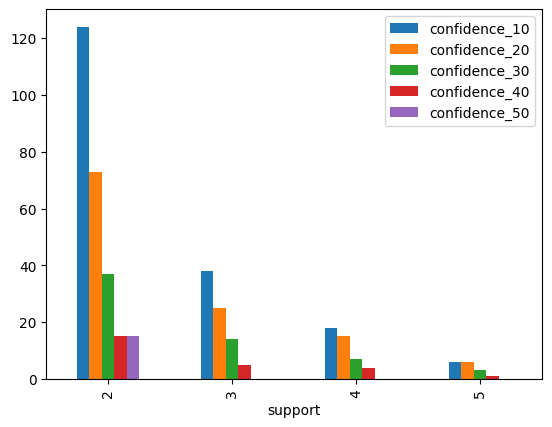

In [508]:
df.plot.bar(x='support')

### it can be seen that as the support % and confidence % increases the number of rules drastically decrease. 

# Part 2 - FPgrowth

In [509]:
# (c) 2014 Reid Johnson
#
# Modified from:
# Eric Naeseth <eric@naeseth.com>
# (https://github.com/enaeseth/python-fp-growth/blob/master/fp_growth.py)
#
# A Python implementation of the FP-growth algorithm.

from collections import defaultdict, namedtuple
import csv
import numpy as np
#from itertools import imap

__author__ = 'Eric Naeseth <eric@naeseth.com>'
__copyright__ = 'Copyright © 2009 Eric Naeseth'
__license__ = 'MIT License'

def fpgrowth(dataset, min_support=0.5, include_support=True, verbose=False):
    """Implements the FP-growth algorithm.

    The `dataset` parameter can be any iterable of iterables of items.
    `min_support` should be an integer specifying the minimum number of
    occurrences of an itemset for it to be accepted.

    Each item must be hashable (i.e., it must be valid as a member of a
    dictionary or a set).

    If `include_support` is true, yield (itemset, support) pairs instead of
    just the itemsets.

    Parameters
    ----------
    dataset : list
        The dataset (a list of transactions) from which to generate 
        candidate itemsets.

    min_support : float
        The minimum support threshold. Defaults to 0.5.

    include_support : bool
        Include support in output (default=False).

    References
    ----------
    .. [1] J. Han, J. Pei, Y. Yin, "Mining Frequent Patterns without Candidate 
           Generation," 2000.

    """

    F = []
    support_data = {}
    for k,v in find_frequent_itemsets(dataset, min_support=min_support, include_support=include_support, verbose=verbose):
        F.append(frozenset(k))
        support_data[frozenset(k)] = v

    # Create one array with subarrays that hold all transactions of equal length.
    def bucket_list(nested_list, sort=True):
        bucket = defaultdict(list)
        for sublist in nested_list:
            bucket[len(sublist)].append(sublist)
        return [v for k,v in sorted(bucket.items())] if sort else bucket.values()

    F = bucket_list(F)
    
    return F, support_data

def find_frequent_itemsets(dataset, min_support, include_support=False, verbose=False):
    """
    Find frequent itemsets in the given transactions using FP-growth. This
    function returns a generator instead of an eagerly-populated list of items.

    The `dataset` parameter can be any iterable of iterables of items.
    `min_support` should be an integer specifying the minimum number of
    occurrences of an itemset for it to be accepted.

    Each item must be hashable (i.e., it must be valid as a member of a
    dictionary or a set).

    If `include_support` is true, yield (itemset, support) pairs instead of
    just the itemsets.

    Parameters
    ----------
    dataset : list
        The dataset (a list of transactions) from which to generate 
        candidate itemsets.

    min_support : float
        The minimum support threshold. Defaults to 0.5.

    include_support : bool
        Include support in output (default=False).

    """
    items = defaultdict(lambda: 0) # mapping from items to their supports
    processed_transactions = []

    # Load the passed-in transactions and count the support that individual
    # items have.
    for transaction in dataset:
        processed = []
        for item in transaction:
            items[item] += 1
            processed.append(item)
        processed_transactions.append(processed)

    # Remove infrequent items from the item support dictionary.
    items = dict((item, support) for item, support in items.items()
        if support >= min_support)

    # Build our FP-tree. Before any transactions can be added to the tree, they
    # must be stripped of infrequent items and their surviving items must be
    # sorted in decreasing order of frequency.
    def clean_transaction(transaction):
        #transaction = filter(lambda v: v in items, transaction)
        transaction.sort(key=lambda v: items[v], reverse=True)
        return transaction

    master = FPTree()
    for transaction in map(clean_transaction, processed_transactions):
        master.add(transaction)

    support_data = {}
    def find_with_suffix(tree, suffix):
        for item, nodes in tree.items():
            support = float(sum(n.count for n in nodes)) / len(dataset)
            if support >= min_support and item not in suffix:
                # New winner!
                found_set = [item] + suffix
                support_data[frozenset(found_set)] = support
                yield (found_set, support) if include_support else found_set

                # Build a conditional tree and recursively search for frequent
                # itemsets within it.
                cond_tree = conditional_tree_from_paths(tree.prefix_paths(item),
                    min_support)
                for s in find_with_suffix(cond_tree, found_set):
                    yield s # pass along the good news to our caller

    if verbose:
        # Print a list of all the frequent itemsets.
        for itemset, support in find_with_suffix(master, []):
            print("" \
                + "{" \
                + "".join(str(i) + ", " for i in iter(itemset)).rstrip(', ') \
                + "}" \
                + ":  sup = " + str(round(support_data[frozenset(itemset)], 3)))

    # Search for frequent itemsets, and yield the results we find.
    for itemset in find_with_suffix(master, []):
        yield itemset

class FPTree(object):
    """
    An FP tree.

    This object may only store transaction items that are hashable (i.e., all
    items must be valid as dictionary keys or set members).
    """

    Route = namedtuple('Route', 'head tail')

    def __init__(self):
        # The root node of the tree.
        self._root = FPNode(self, None, None)

        # A dictionary mapping items to the head and tail of a path of
        # "neighbors" that will hit every node containing that item.
        self._routes = {}

    @property
    def root(self):
        """The root node of the tree."""
        return self._root

    def add(self, transaction):
        """
        Adds a transaction to the tree.
        """

        point = self._root

        for item in transaction:
            next_point = point.search(item)
            if next_point:
                # There is already a node in this tree for the current
                # transaction item; reuse it.
                next_point.increment()
            else:
                # Create a new point and add it as a child of the point we're
                # currently looking at.
                next_point = FPNode(self, item)
                point.add(next_point)

                # Update the route of nodes that contain this item to include
                # our new node.
                self._update_route(next_point)

            point = next_point

    def _update_route(self, point):
        """Add the given node to the route through all nodes for its item."""
        assert self is point.tree

        try:
            route = self._routes[point.item]
            route[1].neighbor = point # route[1] is the tail
            self._routes[point.item] = self.Route(route[0], point)
        except KeyError:
            # First node for this item; start a new route.
            self._routes[point.item] = self.Route(point, point)

    def items(self):
        """
        Generate one 2-tuples for each item represented in the tree. The first
        element of the tuple is the item itself, and the second element is a
        generator that will yield the nodes in the tree that belong to the item.
        """
        for item in self._routes.keys():
            yield (item, self.nodes(item))

            
    def nodes(self, item):
        """
        Generates the sequence of nodes that contain the given item.
        """

        try:
            node = self._routes[item][0]
        except KeyError:
            return

        while node:
            yield node
            node = node.neighbor

    def prefix_paths(self, item):
        """Generates the prefix paths that end with the given item."""

        def collect_path(node):
            path = []
            while node and not node.root:
                path.append(node)
                node = node.parent
            path.reverse()
            return path

        return (collect_path(node) for node in self.nodes(item))

    def inspect(self):
        print("Tree:")
        self.root.inspect(1)

        print("")
        print("Routes:")
        for item, nodes in self.items():
            print("  %r" % item)
            for node in nodes:
                print("    %r" % node)

    def _removed(self, node):
        """Called when `node` is removed from the tree; performs cleanup."""

        head, tail = self._routes[node.item]
        if node is head:
            if node is tail or not node.neighbor:
                # It was the sole node.
                del self._routes[node.item]
            else:
                self._routes[node.item] = self.Route(node.neighbor, tail)
        else:
            for n in self.nodes(node.item):
                if n.neighbor is node:
                    n.neighbor = node.neighbor # skip over
                    if node is tail:
                        self._routes[node.item] = self.Route(head, n)
                    break

def conditional_tree_from_paths(paths, min_support):
    """Builds a conditional FP-tree from the given prefix paths."""
    tree = FPTree()
    condition_item = None
    items = set()

    # Import the nodes in the paths into the new tree. Only the counts of the
    # leaf notes matter; the remaining counts will be reconstructed from the
    # leaf counts.
    for path in paths:
        if condition_item is None:
            condition_item = path[-1].item

        point = tree.root
        for node in path:
            next_point = point.search(node.item)
            if not next_point:
                # Add a new node to the tree.
                items.add(node.item)
                count = node.count if node.item == condition_item else 0
                next_point = FPNode(tree, node.item, count)
                point.add(next_point)
                tree._update_route(next_point)
            point = next_point

    assert condition_item is not None

    # Calculate the counts of the non-leaf nodes.
    for path in tree.prefix_paths(condition_item):
        count = path[-1].count
        for node in reversed(path[:-1]):
            node._count += count

    # Eliminate the nodes for any items that are no longer frequent.
    for item in items:
        support = sum(n.count for n in tree.nodes(item))
        if support < min_support:
            # Doesn't make the cut anymore
            for node in tree.nodes(item):
                if node.parent is not None:
                    node.parent.remove(node)

    # Finally, remove the nodes corresponding to the item for which this
    # conditional tree was generated.
    for node in tree.nodes(condition_item):
        if node.parent is not None: # the node might already be an orphan
            node.parent.remove(node)

    return tree

class FPNode(object):
    """A node in an FP tree."""

    def __init__(self, tree, item, count=1):
        self._tree = tree
        self._item = item
        self._count = count
        self._parent = None
        self._children = {}
        self._neighbor = None

    def add(self, child):
        """Adds the given FPNode `child` as a child of this node."""

        if not isinstance(child, FPNode):
            raise TypeError("Can only add other FPNodes as children")

        if not child.item in self._children:
            self._children[child.item] = child
            child.parent = self

    def search(self, item):
        """
        Checks to see if this node contains a child node for the given item.
        If so, that node is returned; otherwise, `None` is returned.
        """

        try:
            return self._children[item]
        except KeyError:
            return None

    def remove(self, child):
        try:
            if self._children[child.item] is child:
                del self._children[child.item]
                child.parent = None
                self._tree._removed(child)
                for sub_child in child.children:
                    try:
                        # Merger case: we already have a child for that item, so
                        # add the sub-child's count to our child's count.
                        self._children[sub_child.item]._count += sub_child.count
                        sub_child.parent = None # it's an orphan now
                    except KeyError:
                        # Turns out we don't actually have a child, so just add
                        # the sub-child as our own child.
                        self.add(sub_child)
                child._children = {}
            else:
                raise ValueError("that node is not a child of this node")
        except KeyError:
            raise ValueError("that node is not a child of this node")

    def __contains__(self, item):
        return item in self._children

    @property
    def tree(self):
        """The tree in which this node appears."""
        return self._tree

    @property
    def item(self):
        """The item contained in this node."""
        return self._item

    @property
    def count(self):
        """The count associated with this node's item."""
        return self._count

    def increment(self):
        """Increments the count associated with this node's item."""
        if self._count is None:
            raise ValueError("Root nodes have no associated count.")
        self._count += 1

    @property
    def root(self):
        """True if this node is the root of a tree; false if otherwise."""
        return self._item is None and self._count is None

    @property
    def leaf(self):
        """True if this node is a leaf in the tree; false if otherwise."""
        return len(self._children) == 0

    def parent():
        doc = "The node's parent."
        def fget(self):
            return self._parent
        def fset(self, value):
            if value is not None and not isinstance(value, FPNode):
                raise TypeError("A node must have an FPNode as a parent.")
            if value and value.tree is not self.tree:
                raise ValueError("Cannot have a parent from another tree.")
            self._parent = value
        return locals()
    parent = property(**parent())

    def neighbor():
        doc = """
        The node's neighbor; the one with the same value that is "to the right"
        of it in the tree.
        """
        def fget(self):
            return self._neighbor
        def fset(self, value):
            if value is not None and not isinstance(value, FPNode):
                raise TypeError("A node must have an FPNode as a neighbor.")
            if value and value.tree is not self.tree:
                raise ValueError("Cannot have a neighbor from another tree.")
            self._neighbor = value
        return locals()
    neighbor = property(**neighbor())

    @property
    def children(self):
        """The nodes that are children of this node."""
        return tuple(self._children.values())
        
    def inspect(self, depth=0):
        print(('  ' * depth) + repr(self))
        for child in self.children:
            child.inspect(depth + 1)

    def __repr__(self):
        if self.root:
            return "<%s (root)>" % type(self).__name__
        return "<%s %r (%r)>" % (type(self).__name__, self.item, self.count)

def rules_from_conseq(freq_set, H, support_data, rules, min_confidence=0.5, verbose=False):
    """Generates a set of candidate rules.

    Parameters
    ----------
    freq_set : frozenset
        The complete list of frequent itemsets.

    H : list
        A list of frequent itemsets (of a particular length).

    support_data : dict
        The support data for all candidate itemsets.

    rules : list
        A potentially incomplete set of candidate rules above the minimum 
        confidence threshold.

    min_confidence : float
        The minimum confidence threshold. Defaults to 0.5.
    """
    m = len(H[0])
    if m == 1:
        Hmp1 = calc_confidence(freq_set, H, support_data, rules, min_confidence, verbose)
    if (len(freq_set) > (m+1)):
        Hmp1 = apriori_gen(H, m+1) # generate candidate itemsets
        Hmp1 = calc_confidence(freq_set, Hmp1,  support_data, rules, min_confidence, verbose)
        if len(Hmp1) > 1:
            # If there are candidate rules above the minimum confidence 
            # threshold, recurse on the list of these candidate rules.
            rules_from_conseq(freq_set, Hmp1, support_data, rules, min_confidence, verbose)

def calc_confidence(freq_set, H, support_data, rules, min_confidence=0.5, verbose=False):
    """Evaluates the generated rules.

    One measurement for quantifying the goodness of association rules is 
    confidence. The confidence for a rule 'P implies H' (P -> H) is defined as 
    the support for P and H divided by the support for P 
    (support (P|H) / support(P)), where the | symbol denotes the set union 
    (thus P|H means all the items in set P or in set H).

    To calculate the confidence, we iterate through the frequent itemsets and 
    associated support data. For each frequent itemset, we divide the support 
    of the itemset by the support of the antecedent (left-hand-side of the 
    rule).

    Parameters
    ----------
    freq_set : frozenset
        The complete list of frequent itemsets.

    H : list
        A list of frequent itemsets (of a particular length).

    min_support : float
        The minimum support threshold.

    rules : list
        A potentially incomplete set of candidate rules above the minimum 
        confidence threshold.

    min_confidence : float
        The minimum confidence threshold. Defaults to 0.5.

    Returns
    -------
    pruned_H : list
        The list of candidate rules above the minimum confidence threshold.
    """
    pruned_H = [] # list of candidate rules above the minimum confidence threshold
    for conseq in H: # iterate over the frequent itemsets
        conf = support_data[freq_set] / support_data[freq_set - conseq]
        if conf >= min_confidence:
            rules.append((freq_set - conseq, conseq, conf))
            pruned_H.append(conseq)

            if verbose:
                print("" \
                    + "{" \
                    + "".join([str(i) + ", " for i in iter(freq_set-conseq)]).rstrip(', ') \
                    + "}" \
                    + " ---> " \
                    + "{" \
                    + "".join([str(i) + ", " for i in iter(conseq)]).rstrip(', ') \
                    + "}" \
                    + ":  conf = " + str(round(conf, 3)) \
                    + ", sup = " + str(round(support_data[freq_set], 3)))

    return pruned_H

def generate_rules(F, support_data, min_confidence=0.5, verbose=True):
    """Generates a set of candidate rules from a list of frequent itemsets.

    For each frequent itemset, we calculate the confidence of using a
    particular item as the rule consequent (right-hand-side of the rule). By 
    testing and merging the remaining rules, we recursively create a list of 
    pruned rules.

    Parameters
    ----------
    F : list
        A list of frequent itemsets.

    support_data : dict
        The corresponding support data for the frequent itemsets (L).

    min_confidence : float
        The minimum confidence threshold. Defaults to 0.5.

    Returns
    -------
    rules : list
        The list of candidate rules above the minimum confidence threshold.
    """
    rules = []
    for i in range(1, len(F)):
        for freq_set in F[i]:
            H1 = [frozenset([item]) for item in freq_set]
            if (i > 1):
                rules_from_conseq(freq_set, H1, support_data, rules, min_confidence, verbose)
            else:
                calc_confidence(freq_set, H1, support_data, rules, min_confidence, verbose)

    return rules
# Load the grocery.csv file and convert into data array to further process it for the FP growth function
def load_dataset(filename):
    '''Loads an example of market basket transactions from a provided csv file.

    Returns: A list (database) of lists (transactions). Each element of a transaction is 
    an item.
    '''

    with open(filename,'r') as dest_f:
        data_iter = csv.reader(dest_f, delimiter = ',', quotechar = '"')
        data = [data for data in data_iter]
        data_array = np.asarray(data)
        
    return data_array

In [510]:
dataset = load_dataset('grocery.csv')
D = list(map(set, dataset))

/var/folders/w7/4qn17rqj6dj91d1s17qbtz700000gn/T/ipykernel_85112/1196753518.py:596: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  data_array = np.asarray(data)


### support 2%

In [511]:
# Generate all the frequent itemsets using the fp gorwth algorithm. min support : 2%
Fp1, support_data_1 = fpgrowth(dataset, min_support=0.02, verbose=True)

{citrus fruit}:  sup = 0.083
{whole milk, citrus fruit}:  sup = 0.031
{yogurt, citrus fruit}:  sup = 0.022
{other vegetables, citrus fruit}:  sup = 0.029
{margarine}:  sup = 0.059
{whole milk, margarine}:  sup = 0.024
{yogurt}:  sup = 0.14
{whole milk, yogurt}:  sup = 0.056
{soda, yogurt}:  sup = 0.027
{rolls/buns, yogurt}:  sup = 0.034
{other vegetables, yogurt}:  sup = 0.043
{whole milk, other vegetables, yogurt}:  sup = 0.022
{tropical fruit}:  sup = 0.105
{yogurt, tropical fruit}:  sup = 0.029
{other vegetables, tropical fruit}:  sup = 0.036
{whole milk, tropical fruit}:  sup = 0.042
{rolls/buns, tropical fruit}:  sup = 0.025
{root vegetables, tropical fruit}:  sup = 0.021
{soda, tropical fruit}:  sup = 0.021
{coffee}:  sup = 0.058
{whole milk}:  sup = 0.256
{pip fruit}:  sup = 0.076
{whole milk, pip fruit}:  sup = 0.03
{tropical fruit, pip fruit}:  sup = 0.02
{other vegetables, pip fruit}:  sup = 0.026
{cream cheese}:  sup = 0.04
{other vegetables}:  sup = 0.193
{whole milk, other

In [512]:
# Generate the association rules from a list of frequent itemsets. min confidence : 10%
fprules_c10_s2 = generate_rules(Fp1, support_data_1, min_confidence=0.1, verbose=True)

{whole milk} ---> {citrus fruit}:  conf = 0.119, sup = 0.031
{citrus fruit} ---> {whole milk}:  conf = 0.369, sup = 0.031
{citrus fruit} ---> {yogurt}:  conf = 0.262, sup = 0.022
{yogurt} ---> {citrus fruit}:  conf = 0.155, sup = 0.022
{citrus fruit} ---> {other vegetables}:  conf = 0.349, sup = 0.029
{other vegetables} ---> {citrus fruit}:  conf = 0.149, sup = 0.029
{margarine} ---> {whole milk}:  conf = 0.413, sup = 0.024
{whole milk} ---> {yogurt}:  conf = 0.219, sup = 0.056
{yogurt} ---> {whole milk}:  conf = 0.402, sup = 0.056
{soda} ---> {yogurt}:  conf = 0.157, sup = 0.027
{yogurt} ---> {soda}:  conf = 0.196, sup = 0.027
{yogurt} ---> {rolls/buns}:  conf = 0.246, sup = 0.034
{rolls/buns} ---> {yogurt}:  conf = 0.187, sup = 0.034
{other vegetables} ---> {yogurt}:  conf = 0.224, sup = 0.043
{yogurt} ---> {other vegetables}:  conf = 0.311, sup = 0.043
{tropical fruit} ---> {yogurt}:  conf = 0.279, sup = 0.029
{yogurt} ---> {tropical fruit}:  conf = 0.21, sup = 0.029
{other vegetabl

In [513]:
# Generate the association rules from a list of frequent itemsets. min confidence : 20%
fprules_c20_s2 = generate_rules(Fp1, support_data_1, min_confidence=0.2, verbose=True)

{citrus fruit} ---> {whole milk}:  conf = 0.369, sup = 0.031
{citrus fruit} ---> {yogurt}:  conf = 0.262, sup = 0.022
{citrus fruit} ---> {other vegetables}:  conf = 0.349, sup = 0.029
{margarine} ---> {whole milk}:  conf = 0.413, sup = 0.024
{whole milk} ---> {yogurt}:  conf = 0.219, sup = 0.056
{yogurt} ---> {whole milk}:  conf = 0.402, sup = 0.056
{yogurt} ---> {rolls/buns}:  conf = 0.246, sup = 0.034
{other vegetables} ---> {yogurt}:  conf = 0.224, sup = 0.043
{yogurt} ---> {other vegetables}:  conf = 0.311, sup = 0.043
{tropical fruit} ---> {yogurt}:  conf = 0.279, sup = 0.029
{yogurt} ---> {tropical fruit}:  conf = 0.21, sup = 0.029
{tropical fruit} ---> {other vegetables}:  conf = 0.342, sup = 0.036
{tropical fruit} ---> {whole milk}:  conf = 0.403, sup = 0.042
{tropical fruit} ---> {rolls/buns}:  conf = 0.234, sup = 0.025
{tropical fruit} ---> {root vegetables}:  conf = 0.201, sup = 0.021
{pip fruit} ---> {whole milk}:  conf = 0.398, sup = 0.03
{pip fruit} ---> {tropical fruit}

In [514]:
# Generate the association rules from a list of frequent itemsets. min confidence : 30%
fprules_c30_s2 = generate_rules(Fp1, support_data_1, min_confidence=0.3, verbose=True)

{citrus fruit} ---> {whole milk}:  conf = 0.369, sup = 0.031
{citrus fruit} ---> {other vegetables}:  conf = 0.349, sup = 0.029
{margarine} ---> {whole milk}:  conf = 0.413, sup = 0.024
{yogurt} ---> {whole milk}:  conf = 0.402, sup = 0.056
{yogurt} ---> {other vegetables}:  conf = 0.311, sup = 0.043
{tropical fruit} ---> {other vegetables}:  conf = 0.342, sup = 0.036
{tropical fruit} ---> {whole milk}:  conf = 0.403, sup = 0.042
{pip fruit} ---> {whole milk}:  conf = 0.398, sup = 0.03
{pip fruit} ---> {other vegetables}:  conf = 0.345, sup = 0.026
{other vegetables} ---> {whole milk}:  conf = 0.387, sup = 0.075
{butter} ---> {whole milk}:  conf = 0.497, sup = 0.028
{butter} ---> {other vegetables}:  conf = 0.361, sup = 0.02
{rolls/buns} ---> {whole milk}:  conf = 0.308, sup = 0.057
{bottled water} ---> {whole milk}:  conf = 0.311, sup = 0.034
{curd} ---> {whole milk}:  conf = 0.49, sup = 0.026
{beef} ---> {whole milk}:  conf = 0.405, sup = 0.021
{frankfurter} ---> {whole milk}:  conf 

In [515]:
# Generate the association rules from a list of frequent itemsets. min confidence : 40%
fprules_c40_s2 = generate_rules(Fp1, support_data_1, min_confidence=0.4, verbose=True)

{margarine} ---> {whole milk}:  conf = 0.413, sup = 0.024
{yogurt} ---> {whole milk}:  conf = 0.402, sup = 0.056
{tropical fruit} ---> {whole milk}:  conf = 0.403, sup = 0.042
{butter} ---> {whole milk}:  conf = 0.497, sup = 0.028
{curd} ---> {whole milk}:  conf = 0.49, sup = 0.026
{beef} ---> {whole milk}:  conf = 0.405, sup = 0.021
{root vegetables} ---> {other vegetables}:  conf = 0.435, sup = 0.047
{root vegetables} ---> {whole milk}:  conf = 0.449, sup = 0.049
{whipped/sour cream} ---> {whole milk}:  conf = 0.45, sup = 0.032
{whipped/sour cream} ---> {other vegetables}:  conf = 0.403, sup = 0.029
{domestic eggs} ---> {whole milk}:  conf = 0.473, sup = 0.03
{frozen vegetables} ---> {whole milk}:  conf = 0.425, sup = 0.02
{yogurt, other vegetables} ---> {whole milk}:  conf = 0.513, sup = 0.022
{whole milk, root vegetables} ---> {other vegetables}:  conf = 0.474, sup = 0.023
{other vegetables, root vegetables} ---> {whole milk}:  conf = 0.489, sup = 0.023


In [516]:
# Generate the association rules from a list of frequent itemsets. min confidence : 50%
fprules_c50_s2 = generate_rules(Fp1, support_data_1, min_confidence=0.5, verbose=True)

{yogurt, other vegetables} ---> {whole milk}:  conf = 0.513, sup = 0.022


### support 3%

In [517]:
# Generate all the frequent itemsets using the fp gorwth algorithm. min support : 3%
Fp2, support_data_2 = fpgrowth(dataset, min_support=0.03, verbose=True)


{citrus fruit}:  sup = 0.083
{whole milk, citrus fruit}:  sup = 0.031
{margarine}:  sup = 0.059
{yogurt}:  sup = 0.14
{whole milk, yogurt}:  sup = 0.056
{rolls/buns, yogurt}:  sup = 0.034
{other vegetables, yogurt}:  sup = 0.043
{tropical fruit}:  sup = 0.105
{other vegetables, tropical fruit}:  sup = 0.036
{whole milk, tropical fruit}:  sup = 0.042
{coffee}:  sup = 0.058
{whole milk}:  sup = 0.256
{pip fruit}:  sup = 0.076
{whole milk, pip fruit}:  sup = 0.03
{cream cheese}:  sup = 0.04
{other vegetables}:  sup = 0.193
{whole milk, other vegetables}:  sup = 0.075
{long life bakery product}:  sup = 0.037
{butter}:  sup = 0.055
{rolls/buns}:  sup = 0.184
{other vegetables, rolls/buns}:  sup = 0.043
{whole milk, rolls/buns}:  sup = 0.057
{bottled beer}:  sup = 0.081
{UHT-milk}:  sup = 0.033
{bottled water}:  sup = 0.111
{whole milk, bottled water}:  sup = 0.034
{chocolate}:  sup = 0.05
{white bread}:  sup = 0.042
{curd}:  sup = 0.053
{beef}:  sup = 0.052
{soda}:  sup = 0.174
{rolls/buns,

In [518]:
# Generate the association rules from a list of frequent itemsets. min confidence : 10%
fprules_c10_s3 = generate_rules(Fp2, support_data_2, min_confidence=0.1, verbose=True)


{whole milk} ---> {citrus fruit}:  conf = 0.119, sup = 0.031
{citrus fruit} ---> {whole milk}:  conf = 0.369, sup = 0.031
{whole milk} ---> {yogurt}:  conf = 0.219, sup = 0.056
{yogurt} ---> {whole milk}:  conf = 0.402, sup = 0.056
{yogurt} ---> {rolls/buns}:  conf = 0.246, sup = 0.034
{rolls/buns} ---> {yogurt}:  conf = 0.187, sup = 0.034
{other vegetables} ---> {yogurt}:  conf = 0.224, sup = 0.043
{yogurt} ---> {other vegetables}:  conf = 0.311, sup = 0.043
{other vegetables} ---> {tropical fruit}:  conf = 0.185, sup = 0.036
{tropical fruit} ---> {other vegetables}:  conf = 0.342, sup = 0.036
{whole milk} ---> {tropical fruit}:  conf = 0.166, sup = 0.042
{tropical fruit} ---> {whole milk}:  conf = 0.403, sup = 0.042
{whole milk} ---> {pip fruit}:  conf = 0.118, sup = 0.03
{pip fruit} ---> {whole milk}:  conf = 0.398, sup = 0.03
{whole milk} ---> {other vegetables}:  conf = 0.293, sup = 0.075
{other vegetables} ---> {whole milk}:  conf = 0.387, sup = 0.075
{other vegetables} ---> {rol

In [519]:
# Generate the association rules from a list of frequent itemsets. min confidence : 20%
fprules_c20_s3 = generate_rules(Fp2, support_data_2, min_confidence=0.2, verbose=True)

{citrus fruit} ---> {whole milk}:  conf = 0.369, sup = 0.031
{whole milk} ---> {yogurt}:  conf = 0.219, sup = 0.056
{yogurt} ---> {whole milk}:  conf = 0.402, sup = 0.056
{yogurt} ---> {rolls/buns}:  conf = 0.246, sup = 0.034
{other vegetables} ---> {yogurt}:  conf = 0.224, sup = 0.043
{yogurt} ---> {other vegetables}:  conf = 0.311, sup = 0.043
{tropical fruit} ---> {other vegetables}:  conf = 0.342, sup = 0.036
{tropical fruit} ---> {whole milk}:  conf = 0.403, sup = 0.042
{pip fruit} ---> {whole milk}:  conf = 0.398, sup = 0.03
{whole milk} ---> {other vegetables}:  conf = 0.293, sup = 0.075
{other vegetables} ---> {whole milk}:  conf = 0.387, sup = 0.075
{other vegetables} ---> {rolls/buns}:  conf = 0.22, sup = 0.043
{rolls/buns} ---> {other vegetables}:  conf = 0.232, sup = 0.043
{whole milk} ---> {rolls/buns}:  conf = 0.222, sup = 0.057
{rolls/buns} ---> {whole milk}:  conf = 0.308, sup = 0.057
{bottled water} ---> {whole milk}:  conf = 0.311, sup = 0.034
{soda} ---> {rolls/buns}

In [520]:
# Generate the association rules from a list of frequent itemsets. min confidence : 30%
fprules_c30_s3 = generate_rules(Fp2, support_data_2, min_confidence=0.3, verbose=True)

{citrus fruit} ---> {whole milk}:  conf = 0.369, sup = 0.031
{yogurt} ---> {whole milk}:  conf = 0.402, sup = 0.056
{yogurt} ---> {other vegetables}:  conf = 0.311, sup = 0.043
{tropical fruit} ---> {other vegetables}:  conf = 0.342, sup = 0.036
{tropical fruit} ---> {whole milk}:  conf = 0.403, sup = 0.042
{pip fruit} ---> {whole milk}:  conf = 0.398, sup = 0.03
{other vegetables} ---> {whole milk}:  conf = 0.387, sup = 0.075
{rolls/buns} ---> {whole milk}:  conf = 0.308, sup = 0.057
{bottled water} ---> {whole milk}:  conf = 0.311, sup = 0.034
{pastry} ---> {whole milk}:  conf = 0.374, sup = 0.033
{root vegetables} ---> {other vegetables}:  conf = 0.435, sup = 0.047
{root vegetables} ---> {whole milk}:  conf = 0.449, sup = 0.049
{sausage} ---> {rolls/buns}:  conf = 0.326, sup = 0.031
{whipped/sour cream} ---> {whole milk}:  conf = 0.45, sup = 0.032


In [521]:
# Generate the association rules from a list of frequent itemsets. min confidence : 40%
fprules_c40_s3 = generate_rules(Fp2, support_data_2, min_confidence=0.4, verbose=True)

{yogurt} ---> {whole milk}:  conf = 0.402, sup = 0.056
{tropical fruit} ---> {whole milk}:  conf = 0.403, sup = 0.042
{root vegetables} ---> {other vegetables}:  conf = 0.435, sup = 0.047
{root vegetables} ---> {whole milk}:  conf = 0.449, sup = 0.049
{whipped/sour cream} ---> {whole milk}:  conf = 0.45, sup = 0.032


In [522]:
# Generate the association rules from a list of frequent itemsets. min confidence : 50%
fprules_c50_s3 = generate_rules(Fp2, support_data_2, min_confidence=0.5, verbose=True)

## support 4%

In [523]:
# Generate all the frequent itemsets using the fp gorwth algorithm. min support : 4%
Fp3, support_data_3 = fpgrowth(dataset, min_support=0.04, verbose=True)

{citrus fruit}:  sup = 0.083
{margarine}:  sup = 0.059
{yogurt}:  sup = 0.14
{whole milk, yogurt}:  sup = 0.056
{other vegetables, yogurt}:  sup = 0.043
{tropical fruit}:  sup = 0.105
{whole milk, tropical fruit}:  sup = 0.042
{coffee}:  sup = 0.058
{whole milk}:  sup = 0.256
{pip fruit}:  sup = 0.076
{other vegetables}:  sup = 0.193
{whole milk, other vegetables}:  sup = 0.075
{butter}:  sup = 0.055
{rolls/buns}:  sup = 0.184
{other vegetables, rolls/buns}:  sup = 0.043
{whole milk, rolls/buns}:  sup = 0.057
{bottled beer}:  sup = 0.081
{bottled water}:  sup = 0.111
{chocolate}:  sup = 0.05
{white bread}:  sup = 0.042
{curd}:  sup = 0.053
{beef}:  sup = 0.052
{soda}:  sup = 0.174
{whole milk, soda}:  sup = 0.04
{frankfurter}:  sup = 0.059
{chicken}:  sup = 0.043
{newspapers}:  sup = 0.08
{fruit/vegetable juice}:  sup = 0.072
{pastry}:  sup = 0.089
{root vegetables}:  sup = 0.109
{other vegetables, root vegetables}:  sup = 0.047
{whole milk, root vegetables}:  sup = 0.049
{canned beer}

In [524]:
# Generate the association rules from a list of frequent itemsets. min confidence : 10%
fprules_c10_s4 = generate_rules(Fp3, support_data_3, min_confidence=0.1, verbose=True)

{whole milk} ---> {yogurt}:  conf = 0.219, sup = 0.056
{yogurt} ---> {whole milk}:  conf = 0.402, sup = 0.056
{other vegetables} ---> {yogurt}:  conf = 0.224, sup = 0.043
{yogurt} ---> {other vegetables}:  conf = 0.311, sup = 0.043
{whole milk} ---> {tropical fruit}:  conf = 0.166, sup = 0.042
{tropical fruit} ---> {whole milk}:  conf = 0.403, sup = 0.042
{whole milk} ---> {other vegetables}:  conf = 0.293, sup = 0.075
{other vegetables} ---> {whole milk}:  conf = 0.387, sup = 0.075
{other vegetables} ---> {rolls/buns}:  conf = 0.22, sup = 0.043
{rolls/buns} ---> {other vegetables}:  conf = 0.232, sup = 0.043
{whole milk} ---> {rolls/buns}:  conf = 0.222, sup = 0.057
{rolls/buns} ---> {whole milk}:  conf = 0.308, sup = 0.057
{soda} ---> {whole milk}:  conf = 0.23, sup = 0.04
{whole milk} ---> {soda}:  conf = 0.157, sup = 0.04
{root vegetables} ---> {other vegetables}:  conf = 0.435, sup = 0.047
{other vegetables} ---> {root vegetables}:  conf = 0.245, sup = 0.047
{root vegetables} --->

In [525]:
# Generate the association rules from a list of frequent itemsets. min confidence : 20%
fprules_c20_s4 = generate_rules(Fp3, support_data_3, min_confidence=0.2, verbose=True)

{whole milk} ---> {yogurt}:  conf = 0.219, sup = 0.056
{yogurt} ---> {whole milk}:  conf = 0.402, sup = 0.056
{other vegetables} ---> {yogurt}:  conf = 0.224, sup = 0.043
{yogurt} ---> {other vegetables}:  conf = 0.311, sup = 0.043
{tropical fruit} ---> {whole milk}:  conf = 0.403, sup = 0.042
{whole milk} ---> {other vegetables}:  conf = 0.293, sup = 0.075
{other vegetables} ---> {whole milk}:  conf = 0.387, sup = 0.075
{other vegetables} ---> {rolls/buns}:  conf = 0.22, sup = 0.043
{rolls/buns} ---> {other vegetables}:  conf = 0.232, sup = 0.043
{whole milk} ---> {rolls/buns}:  conf = 0.222, sup = 0.057
{rolls/buns} ---> {whole milk}:  conf = 0.308, sup = 0.057
{soda} ---> {whole milk}:  conf = 0.23, sup = 0.04
{root vegetables} ---> {other vegetables}:  conf = 0.435, sup = 0.047
{other vegetables} ---> {root vegetables}:  conf = 0.245, sup = 0.047
{root vegetables} ---> {whole milk}:  conf = 0.449, sup = 0.049


In [526]:
# Generate the association rules from a list of frequent itemsets. min confidence : 30%
fprules_c30_s4 = generate_rules(Fp3, support_data_3, min_confidence=0.3, verbose=True)

{yogurt} ---> {whole milk}:  conf = 0.402, sup = 0.056
{yogurt} ---> {other vegetables}:  conf = 0.311, sup = 0.043
{tropical fruit} ---> {whole milk}:  conf = 0.403, sup = 0.042
{other vegetables} ---> {whole milk}:  conf = 0.387, sup = 0.075
{rolls/buns} ---> {whole milk}:  conf = 0.308, sup = 0.057
{root vegetables} ---> {other vegetables}:  conf = 0.435, sup = 0.047
{root vegetables} ---> {whole milk}:  conf = 0.449, sup = 0.049


In [527]:
# Generate the association rules from a list of frequent itemsets. min confidence : 40%
fprules_c40_s4 = generate_rules(Fp3, support_data_3, min_confidence=0.4, verbose=True)

{yogurt} ---> {whole milk}:  conf = 0.402, sup = 0.056
{tropical fruit} ---> {whole milk}:  conf = 0.403, sup = 0.042
{root vegetables} ---> {other vegetables}:  conf = 0.435, sup = 0.047
{root vegetables} ---> {whole milk}:  conf = 0.449, sup = 0.049


In [528]:
# Generate the association rules from a list of frequent itemsets. min confidence : 50%
fprules_c50_s4 = generate_rules(Fp3, support_data_3, min_confidence=0.5, verbose=True)

### support 5%

In [529]:
# Generate all the frequent itemsets using the fp gorwth algorithm. min support : 5%
Fp4, support_data_4 = fpgrowth(dataset, min_support=0.05, verbose=True)

{citrus fruit}:  sup = 0.083
{margarine}:  sup = 0.059
{yogurt}:  sup = 0.14
{whole milk, yogurt}:  sup = 0.056
{tropical fruit}:  sup = 0.105
{coffee}:  sup = 0.058
{whole milk}:  sup = 0.256
{pip fruit}:  sup = 0.076
{other vegetables}:  sup = 0.193
{whole milk, other vegetables}:  sup = 0.075
{butter}:  sup = 0.055
{rolls/buns}:  sup = 0.184
{whole milk, rolls/buns}:  sup = 0.057
{bottled beer}:  sup = 0.081
{bottled water}:  sup = 0.111
{curd}:  sup = 0.053
{beef}:  sup = 0.052
{soda}:  sup = 0.174
{frankfurter}:  sup = 0.059
{newspapers}:  sup = 0.08
{fruit/vegetable juice}:  sup = 0.072
{pastry}:  sup = 0.089
{root vegetables}:  sup = 0.109
{canned beer}:  sup = 0.078
{sausage}:  sup = 0.094
{shopping bags}:  sup = 0.099
{brown bread}:  sup = 0.065
{napkins}:  sup = 0.052
{whipped/sour cream}:  sup = 0.072
{pork}:  sup = 0.058
{domestic eggs}:  sup = 0.063


In [530]:
# Generate the association rules from a list of frequent itemsets. min confidence : 10%
fprules_c10_s5 = generate_rules(Fp4, support_data_4, min_confidence=0.1, verbose=True)

{whole milk} ---> {yogurt}:  conf = 0.219, sup = 0.056
{yogurt} ---> {whole milk}:  conf = 0.402, sup = 0.056
{whole milk} ---> {other vegetables}:  conf = 0.293, sup = 0.075
{other vegetables} ---> {whole milk}:  conf = 0.387, sup = 0.075
{whole milk} ---> {rolls/buns}:  conf = 0.222, sup = 0.057
{rolls/buns} ---> {whole milk}:  conf = 0.308, sup = 0.057


In [531]:
# Generate the association rules from a list of frequent itemsets. min confidence : 20%
fprules_c20_s5 = generate_rules(Fp4, support_data_4, min_confidence=0.2, verbose=True)

{whole milk} ---> {yogurt}:  conf = 0.219, sup = 0.056
{yogurt} ---> {whole milk}:  conf = 0.402, sup = 0.056
{whole milk} ---> {other vegetables}:  conf = 0.293, sup = 0.075
{other vegetables} ---> {whole milk}:  conf = 0.387, sup = 0.075
{whole milk} ---> {rolls/buns}:  conf = 0.222, sup = 0.057
{rolls/buns} ---> {whole milk}:  conf = 0.308, sup = 0.057


In [532]:
# Generate the association rules from a list of frequent itemsets. min confidence : 30%
fprules_c30_s5 = generate_rules(Fp4, support_data_4, min_confidence=0.3, verbose=True)

{yogurt} ---> {whole milk}:  conf = 0.402, sup = 0.056
{other vegetables} ---> {whole milk}:  conf = 0.387, sup = 0.075
{rolls/buns} ---> {whole milk}:  conf = 0.308, sup = 0.057


In [533]:
# Generate the association rules from a list of frequent itemsets. min confidence : 40%
fprules_c40_s5 = generate_rules(Fp4, support_data_4, min_confidence=0.4, verbose=True)

{yogurt} ---> {whole milk}:  conf = 0.402, sup = 0.056


In [534]:
# Generate the association rules from a list of frequent itemsets. min confidence : 50%
fprules_c50_s5 = generate_rules(Fp4, support_data_4, min_confidence=0.5, verbose=True)

## plotting results for fp growth

<AxesSubplot: xlabel='support'>

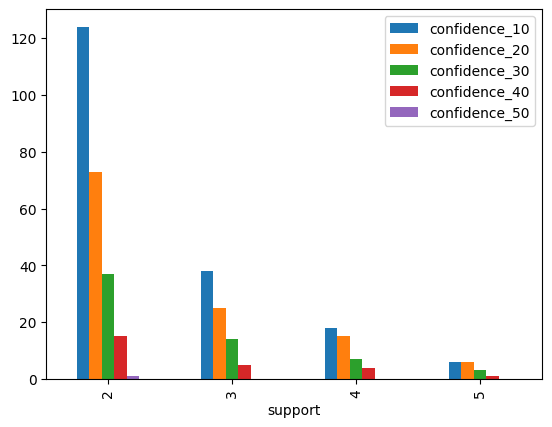

In [535]:
fsupport2 = [len(fprules_c10_s2),len(fprules_c20_s2),len(fprules_c30_s2),len(fprules_c40_s2),len(fprules_c50_s2)]
fsupport3 = [len(fprules_c10_s3),len(fprules_c20_s3),len(fprules_c30_s3),len(fprules_c40_s3),len(fprules_c50_s3)]
fsupport4 = [len(fprules_c10_s4),len(fprules_c20_s4),len(fprules_c30_s4),len(fprules_c40_s4),len(fprules_c50_s4)]
fsupport5 = [len(fprules_c10_s5),len(fprules_c20_s5),len(fprules_c30_s5),len(fprules_c40_s5),len(fprules_c50_s5)]

fpsupports = [fsupport2,fsupport3,fsupport4,fsupport5]

df2 = pd.DataFrame(fpsupports,columns=['confidence_10','confidence_20','confidence_30','confidence_40','confidence_50'])

df2['support']=support

df2.plot.bar(x='support')

### It can be seen that the results derived by fp growth and apriori are the same. however, fpgrowth results get calculated faster since it uses a tree and doesnt need to go over all the entries everytime when calculating the item sets. 

# Part 3 - Interest Factor 

### Use Apriori  with 4% support and 30% confidence to generate the rules. Now, calculate interest factor for all the rules. Recall, Interest Factor of (A ->B), I(A,B) is (Support(AUB)/(Support(A)*Support(B)))

In [536]:
# Generate all the frequent itemsets using the fp gorwth algorithm. min support : 4%
F_intFac, support_data_intFac = apriori(dataset, min_support=0.04, verbose=True)

candidates:  

{Instant food products, UHT-milk, abrasive cleaner, artif. sweetener, baby cosmetics, baby food, bags, baking powder, bathroom cleaner, beef, berries, beverages, bottled beer, bottled water, brandy, brown bread, butter, butter milk, cake bar, candles, candy, canned beer, canned fish, canned fruit, canned vegetables, cat food, cereals, chewing gum, chicken, chocolate, chocolate marshmallow, citrus fruit, cleaner, cling film/bags, cocoa drinks, coffee, condensed milk, cooking chocolate, cookware, cream, cream cheese , curd, curd cheese, decalcifier, dental care, dessert, detergent, dish cleaner, dishes, dog food, domestic eggs, female sanitary products, finished products, fish, flour, flower (seeds), flower soil/fertilizer, frankfurter, frozen chicken, frozen dessert, frozen fish, frozen fruits, frozen meals, frozen potato products, frozen vegetables, fruit/vegetable juice, grapes, hair spray, ham, hamburger meat, hard cheese, herbs, honey, house keeping products, hygiene 

frequent itemset list:  

{frozen vegetables}:  sup = 0.048
{domestic eggs}:  sup = 0.063
{whipped/sour cream}:  sup = 0.072
{pork}:  sup = 0.058
{napkins}:  sup = 0.052
{shopping bags}:  sup = 0.099
{brown bread}:  sup = 0.065
{sausage}:  sup = 0.094
{canned beer}:  sup = 0.078
{root vegetables}:  sup = 0.109
{pastry}:  sup = 0.089
{newspapers}:  sup = 0.08
{fruit/vegetable juice}:  sup = 0.072
{chicken}:  sup = 0.043
{soda}:  sup = 0.174
{frankfurter}:  sup = 0.059
{beef}:  sup = 0.052
{curd}:  sup = 0.053
{white bread}:  sup = 0.042
{chocolate}:  sup = 0.05
{bottled water}:  sup = 0.111
{bottled beer}:  sup = 0.081
{rolls/buns}:  sup = 0.184
{butter}:  sup = 0.055
{other vegetables}:  sup = 0.193
{pip fruit}:  sup = 0.076
{whole milk}:  sup = 0.256
{yogurt}:  sup = 0.14
{tropical fruit}:  sup = 0.105
{coffee}:  sup = 0.058
{margarine}:  sup = 0.059
{citrus fruit}:  sup = 0.083
{yogurt, other vegetables}:  sup = 0.043
{rolls/buns, whole milk}:  sup = 0.057
{whole milk, soda}:  sup = 

In [537]:
H = generate_rules(F_intFac, support_data_intFac, min_confidence=0.3, verbose=True)

{yogurt} ---> {other vegetables}:  conf = 0.311, sup = 0.043
{rolls/buns} ---> {whole milk}:  conf = 0.308, sup = 0.057
{root vegetables} ---> {whole milk}:  conf = 0.449, sup = 0.049
{root vegetables} ---> {other vegetables}:  conf = 0.435, sup = 0.047
{tropical fruit} ---> {whole milk}:  conf = 0.403, sup = 0.042
{yogurt} ---> {whole milk}:  conf = 0.402, sup = 0.056
{other vegetables} ---> {whole milk}:  conf = 0.387, sup = 0.075


In [538]:
rule = pd.DataFrame(H,columns =['antecedants','consequents','confidence'])
rule

,antecedants,consequents,confidence
0,(yogurt),(other vegetables),0.311224
1,(rolls/buns),(whole milk),0.307905
2,(root vegetables),(whole milk),0.448694
3,(root vegetables),(other vegetables),0.434701
4,(tropical fruit),(whole milk),0.403101
5,(yogurt),(whole milk),0.401603
6,(other vegetables),(whole milk),0.386758


In [539]:
#Calculating interest factor for the rules generated
interest_factor = []
for item in H:
    print(support_data_intFac[item[1]])
    print(item[0],item[1],item[2])
    interest_factor.append((item[0],item[1],item[2]/support_data_intFac[item[1]]))
    #interest_factor.append((support_data[item[0]].Union(support_data[item[1]])/(support_data[item[0]]*support_data[item[1]])))

0.1934926283680732
frozenset({'yogurt'}) frozenset({'other vegetables'}) 0.3112244897959184
0.25551601423487547
frozenset({'rolls/buns'}) frozenset({'whole milk'}) 0.30790491984521834
0.25551601423487547
frozenset({'root vegetables'}) frozenset({'whole milk'}) 0.44869402985074625
0.1934926283680732
frozenset({'root vegetables'}) frozenset({'other vegetables'}) 0.43470149253731344
0.25551601423487547
frozenset({'tropical fruit'}) frozenset({'whole milk'}) 0.40310077519379844
0.25551601423487547
frozenset({'yogurt'}) frozenset({'whole milk'}) 0.40160349854227406
0.25551601423487547
frozenset({'other vegetables'}) frozenset({'whole milk'}) 0.38675775091960063


## Show the rules by sorting the rules in descending order by interest factor. Plot the rules as scatter plot with confidence levels on y-axis and support levels on x-axis. Use colorbar to show the interest factor for each rule.

In [540]:
interestFactor = pd.DataFrame(interest_factor,columns=['antecedants','consequants','interest'])
interest_support = [0.043,0.057,0.049,0.047,0.042,0.056,0.075]
interestFactor['support'] = interest_support
interestFactor['confidence'] = rule['confidence'].copy()
interestFactor['rules'] = ['yogurt->other veggies','rolls->whole milk','root veggies->whole milk','root veggies->other veggies','tropical fruit->whole milk','yogurt->whole milk','other veggies->whole milk']
interestFactor

,antecedants,consequants,interest,support,confidence,rules
0,(yogurt),(other vegetables),1.608457,0.043,0.311224,yogurt->other veggies
1,(rolls/buns),(whole milk),1.205032,0.057,0.307905,rolls->whole milk
2,(root vegetables),(whole milk),1.756031,0.049,0.448694,root veggies->whole milk
3,(root vegetables),(other vegetables),2.246605,0.047,0.434701,root veggies->other veggies
4,(tropical fruit),(whole milk),1.577595,0.042,0.403101,tropical fruit->whole milk
5,(yogurt),(whole milk),1.571735,0.056,0.401603,yogurt->whole milk
6,(other vegetables),(whole milk),1.513634,0.075,0.386758,other veggies->whole milk


In [541]:
interestFactor.sort_values(by = 'interest', ascending=False)

,antecedants,consequants,interest,support,confidence,rules
3,(root vegetables),(other vegetables),2.246605,0.047,0.434701,root veggies->other veggies
2,(root vegetables),(whole milk),1.756031,0.049,0.448694,root veggies->whole milk
0,(yogurt),(other vegetables),1.608457,0.043,0.311224,yogurt->other veggies
4,(tropical fruit),(whole milk),1.577595,0.042,0.403101,tropical fruit->whole milk
5,(yogurt),(whole milk),1.571735,0.056,0.401603,yogurt->whole milk
6,(other vegetables),(whole milk),1.513634,0.075,0.386758,other veggies->whole milk
1,(rolls/buns),(whole milk),1.205032,0.057,0.307905,rolls->whole milk


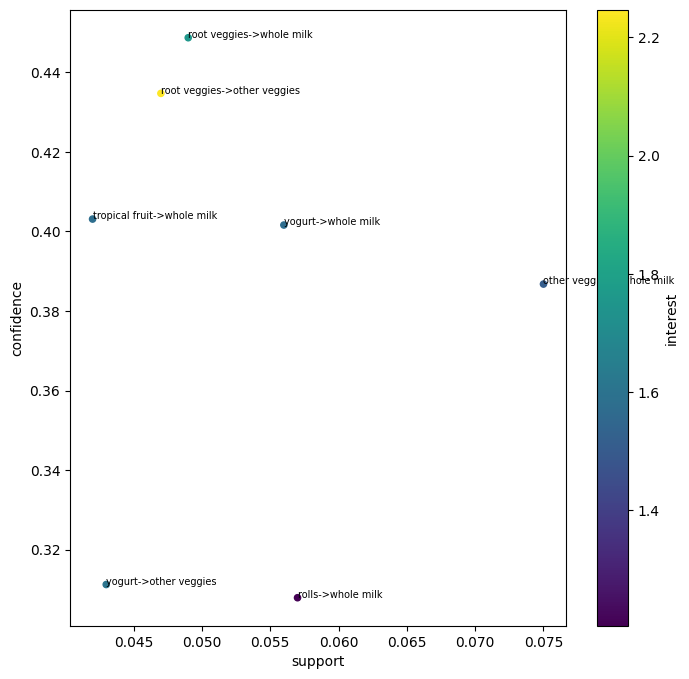

In [542]:
final_plot=interestFactor.plot.scatter(x='support',y='confidence', c='interest',colormap='viridis')

for i, txt in enumerate(interestFactor.rules):
    final_plot.annotate(txt, (interestFactor.support.iat[i],interestFactor.confidence.iat[i]), fontsize=7)
plt.gcf().set_size_inches((8, 8))  


### it can be seen that even though the confidence for some of the rules is very high, this can mean that these rules could be a fluke and this could lead to misinterpretation in the association rules. The intrest factor isnt the highest for some rules with high confidence so this acts as the distinguishing factor in actually knowing which rules are strongest. 
### We can see that a rule root vegetagels-> other vegetables doesnt have highest confidence but has a very high interest factor which means that products of this rule can benefit from being placed in a paritcular arrangement, while the rule with highest confidence : root veggies -> milk doesnt have that high interest, infact it is lower than yogurt-> other veggies and yogurt-> whole milk, both of which have a low confidence.